In [7]:
import json
import joblib
import numpy as np
import os
import seaborn as sns
import tensorflow as tf
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization
from keras.models import Sequential
from keras.utils import to_categorical
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from tabulate import tabulate
from xgboost import XGBClassifier


In [8]:
# Load Data
if os.path.exists('saved_data.joblib') and os.path.exists('saved_labels.joblib'):
    data = joblib.load('saved_data.joblib')
    labels = joblib.load('saved_labels.joblib')
else:
    print("Error: Data files not found.")
    exit()

In [9]:
# Convert labels to numerical values
label_dict = {label: idx for idx, label in enumerate(set(labels))}
numeric_labels = np.array([label_dict[label] for label in labels])
X = np.array(data)
y = np.array(numeric_labels)
# Split the data into training (80%) and testing (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Further split the training data into training and validation sets
# Adjust the validation_split ratio as needed
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

# Reshape the data for CNN
X_train_cnn = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_val_cnn = X_val.reshape(X_val.shape[0], X_val.shape[1], 1)
X_test_cnn = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# Convert labels to one-hot encoded vectors
y_train_onehot = to_categorical(y_train)
y_val_onehot = to_categorical(y_val)
y_test_onehot = to_categorical(y_test)


In [10]:
# Counting samples per genre in training set
train_genre_counts = {label: np.sum(y_train == idx) for label, idx in label_dict.items()}

# Counting samples per genre in testing set
test_genre_counts = {label: np.sum(y_test == idx) for label, idx in label_dict.items()}
# Counting samples per genre in validation set
val_genre_counts = {label: np.sum(y_val == idx) for label, idx in label_dict.items()}


# Convert counts to a list of lists for tabulate
table_data = []

for label, count in train_genre_counts.items():
    table_data.append([label, count, test_genre_counts[label],val_genre_counts[label]])

# Headers for the table
headers = ["Genre", "Training Samples", "Testing Samples","Validation Samples"]

# Print the table
print("Training and Testing Set Samples per Genre:")
print(tabulate(table_data, headers=headers, tablefmt="grid"))

Training and Testing Set Samples per Genre:
+-----------+--------------------+-------------------+----------------------+
| Genre     |   Training Samples |   Testing Samples |   Validation Samples |
+===========+====================+===================+======================+
| hiphop    |                729 |               197 |                   74 |
+-----------+--------------------+-------------------+----------------------+
| pop       |                718 |               198 |                   84 |
+-----------+--------------------+-------------------+----------------------+
| metal     |                712 |               210 |                   78 |
+-----------+--------------------+-------------------+----------------------+
| noise     |                748 |               178 |                   74 |
+-----------+--------------------+-------------------+----------------------+
| country   |                734 |               184 |                   82 |
+-----------+-------

In [11]:

def build_cnn_model(input_shape, filters=64, kernel_size=5, dropout_rate=0.5, l2_reg=0.001):
    model = Sequential()
    model.add(Conv1D(filters, kernel_size, padding='same', activation='relu', input_shape=input_shape, kernel_regularizer=tf.keras.regularizers.l2(l2_reg)))
    model.add(BatchNormalization())
    model.add(MaxPooling1D())

    model.add(Conv1D(filters * 2, kernel_size, padding='same', activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l2_reg)))
    model.add(BatchNormalization())
    model.add(MaxPooling1D())

    model.add(Conv1D(filters * 4, kernel_size, padding='same', activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l2_reg)))
    model.add(BatchNormalization())
    model.add(MaxPooling1D())

    model.add(Flatten())
    model.add(Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l2_reg)))
    model.add(Dropout(dropout_rate))
    model.add(Dense(len(label_dict), activation='softmax')) 

    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    return model

cnn_model = build_cnn_model(input_shape=(X_train_cnn.shape[1], 1))
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.2,
    patience=5, 
    min_lr=0.00001
)

history = cnn_model.fit(
    X_train_cnn, y_train_onehot, epochs=50, batch_size=64,  # Increased epochs and batch size
    validation_data=(X_val_cnn, y_val_onehot),
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 10s 35ms/step - accuracy: 0.2723 - loss: 3.0302 - val_accuracy: 0.2591 - val_loss: 2.7192 - learning_rate: 1.0000e-04
Epoch 2/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.4603 - loss: 2.2121 - val_accuracy: 0.4511 - val_loss: 2.2512 - learning_rate: 1.0000e-04
Epoch 3/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.4984 - loss: 2.0938 - val_accuracy: 0.5705 - val_loss: 2.0082 - learning_rate: 1.0000e-04
Epoch 4/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.5388 - loss: 1.9890 - val_accuracy: 0.6114 - val_loss: 1.8426 - learning_rate: 1.0000e-04
Epoch 5/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.5636 - loss: 1.9177 - val_accuracy: 0.6023 - val_loss: 1.7944 - learning_rate: 1.0000e-04
Epoch 6/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.5860 - loss: 1.8370 - val_accuracy: 0.6284 - val_loss: 1.7197 - learning_rate: 1.0000e-04
Epoch 7/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - ac

In [12]:
print(cnn_model.summary())

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_3 (Conv1D)               │ (None, 38, 64)         │           384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 38, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 19, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ (None, 19, 128)        │        41,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 19, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_4 (MaxPooling1D)  │ (None, 9, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_5 (Conv1D)               │ (None, 9, 256)         │       164,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 9, 256)         │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_5 (MaxPooling1D)  │ (None, 4, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       262,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 11)             │         2,827 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,415,971 (5.40 MB)

 Trainable params: 471,691 (1.80 MB)

 Non-trainable params: 896 (3.50 KB)

 Optimizer params: 943,384 (3.60 MB)

None


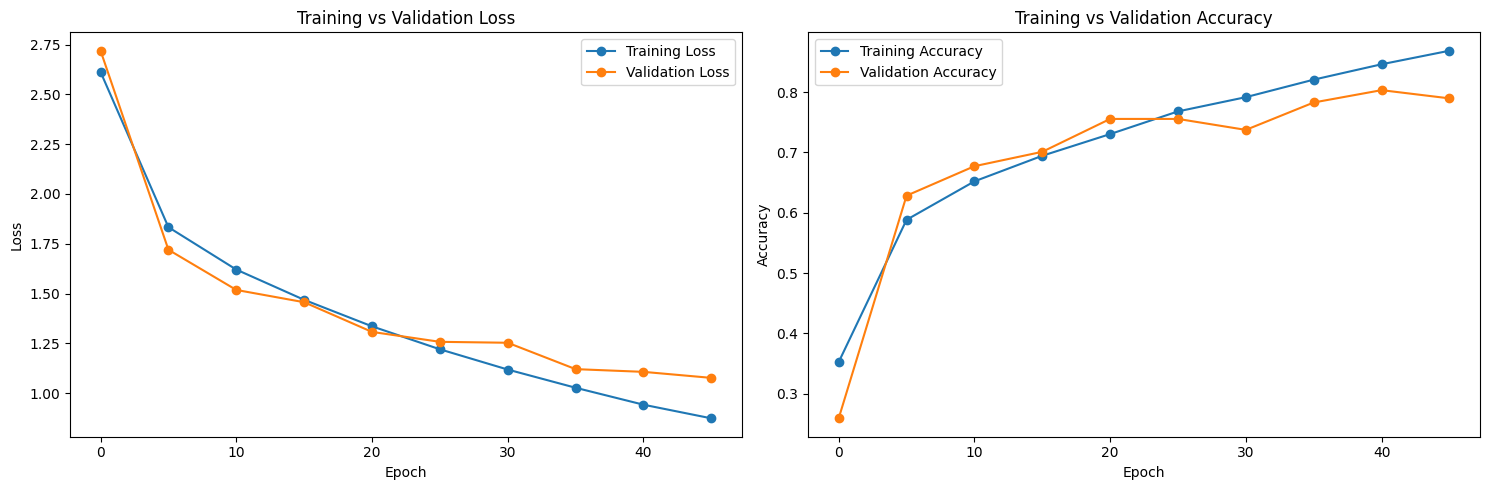

Epoch 5:
	Training Loss: 1.8982, Validation Loss: 1.7944
	Training Accuracy: 57.35%, Validation Accuracy: 60.23%

Epoch 10:
	Training Loss: 1.6582, Validation Loss: 1.5444
	Training Accuracy: 63.98%, Validation Accuracy: 67.95%

Epoch 15:
	Training Loss: 1.4888, Validation Loss: 1.4360
	Training Accuracy: 69.31%, Validation Accuracy: 70.45%

Epoch 20:
	Training Loss: 1.3555, Validation Loss: 1.3472
	Training Accuracy: 72.87%, Validation Accuracy: 72.84%

Epoch 25:
	Training Loss: 1.2313, Validation Loss: 1.2281
	Training Accuracy: 76.48%, Validation Accuracy: 77.61%

Epoch 30:
	Training Loss: 1.1271, Validation Loss: 1.1698
	Training Accuracy: 79.48%, Validation Accuracy: 77.27%

Epoch 35:
	Training Loss: 1.0387, Validation Loss: 1.1455
	Training Accuracy: 81.91%, Validation Accuracy: 79.09%

Epoch 40:
	Training Loss: 0.9575, Validation Loss: 1.1397
	Training Accuracy: 84.24%, Validation Accuracy: 77.16%

Epoch 45:
	Training Loss: 0.8830, Validation Loss: 1.0803
	Training Accuracy: 85.

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))

# Plot every 5 epochs
epochs_to_plot = range(0, len(history.history['accuracy']), 5)

# Plot training vs validation loss
plt.subplot(1, 2, 1)
plt.plot(epochs_to_plot, history.history['loss'][::5], label='Training Loss', marker='o')
plt.plot(epochs_to_plot, history.history['val_loss'][::5], label='Validation Loss', marker='o')
plt.title('Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot training vs validation accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs_to_plot, history.history['accuracy'][::5], label='Training Accuracy', marker='o')
plt.plot(epochs_to_plot, history.history['val_accuracy'][::5], label='Validation Accuracy', marker='o')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# Print and discuss accuracy and loss every 5 epochs
for i in range(4, len(history.history['accuracy']), 5):
    print(f"Epoch {i+1}:")
    print(f"\tTraining Loss: {history.history['loss'][i]:.4f}, Validation Loss: {history.history['val_loss'][i]:.4f}")
    print(f"\tTraining Accuracy: {history.history['accuracy'][i]:.2%}, Validation Accuracy: {history.history['val_accuracy'][i]:.2%}\n")

# Find the epoch with the highest training accuracy and corresponding validation accuracy
max_train_accuracy_epoch = np.argmax(history.history['accuracy']) + 1
max_train_accuracy = np.max(history.history['accuracy'])
corresponding_val_accuracy = history.history['val_accuracy'][max_train_accuracy_epoch - 1]

# Find the epoch with the minimum training loss and corresponding validation loss
min_train_loss_epoch = np.argmin(history.history['loss']) + 1
min_train_loss = np.min(history.history['loss'])
corresponding_val_loss = history.history['val_loss'][min_train_loss_epoch - 1]

# Calculate test accuracy
loss, cnn_test_accuracy = cnn_model.evaluate(X_val_cnn, y_val_onehot)

# Print the results
print(f"Highest Training Accuracy: {max_train_accuracy:.4f} at Epoch {max_train_accuracy_epoch}, Validation Accuracy: {corresponding_val_accuracy:.4f}")
print(f"Minimum Training Loss: {min_train_loss:.4f} at Epoch {min_train_loss_epoch}, Validation Loss: {corresponding_val_loss:.4f}")
print(f"CNN Test Accuracy: {cnn_test_accuracy:.2%}")


In [14]:
# Extract features using the CNN model
cnn_features_train = cnn_model.predict(X_train_cnn)
cnn_features_test = cnn_model.predict(X_val_cnn)

# Scale CNN features for SVM and Random Forest
scaler = StandardScaler()
cnn_features_train_scaled = scaler.fit_transform(cnn_features_train)
cnn_features_val_scaled = scaler.transform(cnn_features_test)

# Train SVM model
svm_model = SVC()
param_grid_svm = {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf', 'poly'], 'gamma': [0.1, 1, 'auto']}
grid_search_svm = GridSearchCV(svm_model, param_grid_svm, cv=3, scoring='accuracy')
grid_search_svm.fit(cnn_features_train_scaled, y_train)
svm_predictions = grid_search_svm.predict(cnn_features_val_scaled)

# Train Random Forest model
rf_model = RandomForestClassifier(
    n_estimators=300,
    max_depth=20,
    min_samples_split=10,
    min_samples_leaf=5,
    random_state=42
)
rf_model.fit(cnn_features_train_scaled, y_train)
rf_predictions = rf_model.predict(cnn_features_val_scaled)

# Train XGBoost model on ensemble input
ensemble_input = np.column_stack((svm_predictions, rf_predictions, np.argmax(cnn_model.predict(X_val_cnn), axis=1)))
xgb_model = XGBClassifier(n_estimators=100, max_depth=3, learning_rate=0.1).fit(ensemble_input, y_val)

# Evaluate the models
svm_accuracy = accuracy_score(y_val, svm_predictions)
rf_accuracy = accuracy_score(y_val, rf_predictions)
xgb_accuracy = accuracy_score(y_val, xgb_model.predict(ensemble_input))

print(f"SVM Model Accuracy: {svm_accuracy:.4f}")
print(f"Random Forest Model Accuracy: {rf_accuracy:.4f}")
print(f"XGBoost Model Accuracy: {xgb_accuracy:.4f}")


248/248 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
SVM Model Accuracy: 0.8182
Random Forest Model Accuracy: 0.8193
XGBoost Model Accuracy: 0.8341


28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


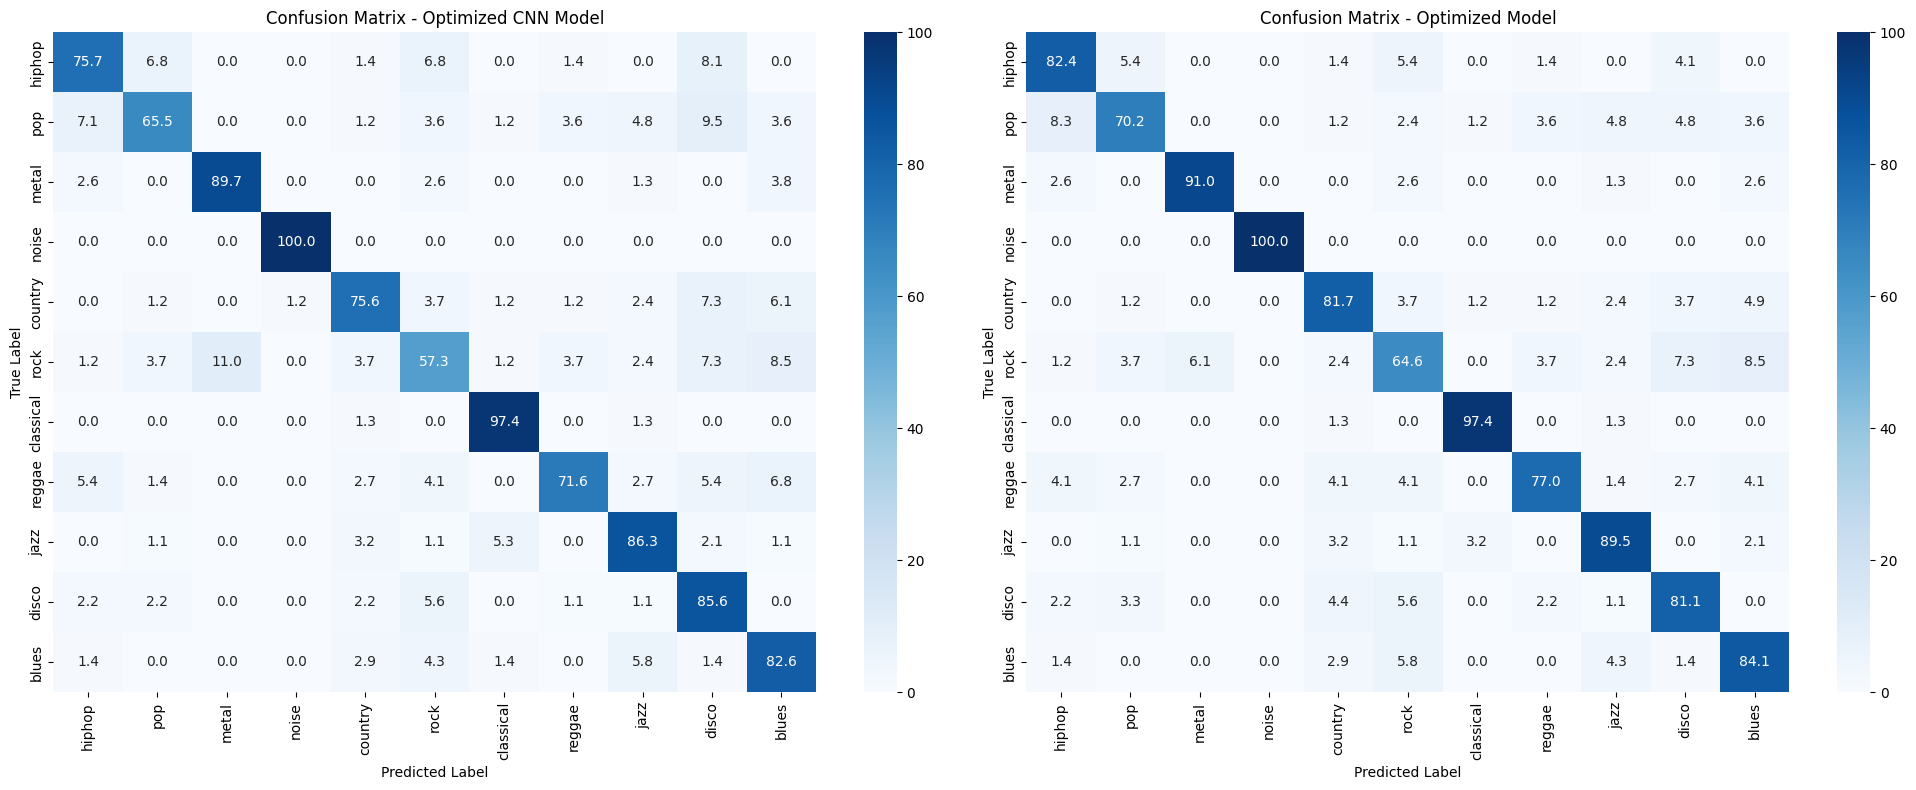

In [15]:
# Compute confusion matrix for the optimized CNN model
y_pred = np.argmax(cnn_model.predict(X_val_cnn), axis=1)
conf_matrix = confusion_matrix(y_val, y_pred)
conf_matrix_percentage = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis] * 100

# Compute confusion matrix for the ensemble model
ensemble_predictions = xgb_model.predict(ensemble_input)
conf_matrix_ensemble = confusion_matrix(y_val, ensemble_predictions)
conf_matrix_ensemble_percentage = conf_matrix_ensemble.astype('float') / conf_matrix_ensemble.sum(axis=1)[:, np.newaxis] * 100

# Plotting
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# Optimized CNN Model Confusion Matrix
sns.heatmap(conf_matrix_percentage, annot=True, fmt='.1f', cmap='Blues', xticklabels=label_dict.keys(), yticklabels=label_dict.keys(), ax=axes[0])
axes[0].set_title('Confusion Matrix - Optimized CNN Model')
axes[0].set_xlabel('Predicted Label')
axes[0].set_ylabel('True Label')

# Ensemble Model Confusion Matrix
sns.heatmap(conf_matrix_ensemble_percentage, annot=True, fmt='.1f', cmap='Blues', xticklabels=label_dict.keys(), yticklabels=label_dict.keys(), ax=axes[1])
axes[1].set_title('Confusion Matrix - Optimized Model')
axes[1].set_xlabel('Predicted Label')
axes[1].set_ylabel('True Label')

plt.tight_layout()
plt.show()


In [16]:


# Predictions for ensemble model
ensemble_predictions = xgb_model.predict(ensemble_input)

# Calculate precision, recall, F1-score, and accuracy for the ensemble model
ensemble_report = classification_report(y_val, ensemble_predictions)
ensemble_accuracy = accuracy_score(y_val, ensemble_predictions)

print("Proposed Model Metrics:")
print(ensemble_report)
print("Proposed Model Accuracy:", ensemble_accuracy)


Proposed Model Metrics:
              precision    recall  f1-score   support

           0       0.79      0.82      0.81        74
           1       0.81      0.70      0.75        84
           2       0.93      0.91      0.92        78
           3       1.00      1.00      1.00        74
           4       0.80      0.82      0.81        82
           5       0.69      0.65      0.67        82
           6       0.94      0.97      0.96        78
           7       0.85      0.77      0.81        74
           8       0.85      0.89      0.87        95
           9       0.79      0.81      0.80        90
          10       0.73      0.84      0.78        69

    accuracy                           0.83       880
   macro avg       0.84      0.84      0.83       880
weighted avg       0.83      0.83      0.83       880

Proposed Model Accuracy: 0.8340909090909091


In [17]:
saved_folder = 'model_folder'

# Create the folder if it doesn't exist
if not os.path.exists(saved_folder):
    os.makedirs(saved_folder)

# Save models
joblib.dump(xgb_model, os.path.join(saved_folder, 'xgb_model.joblib'))
joblib.dump(grid_search_svm, os.path.join(saved_folder, 'svm_model.joblib'))
joblib.dump(rf_model, os.path.join(saved_folder, 'rf_model.joblib'))
# Save CNN model
cnn_model.save(os.path.join(saved_folder, 'cnn_model.h5'))

# baseline_cnn_model.save(os.path.join(saved_folder, 'baseline_cnn_model.h5'))


# Save data arrays
np.save(os.path.join(saved_folder, 'ensemble_input.npy'), ensemble_input)
np.save(os.path.join(saved_folder, 'y_test.npy'), y_test)
np.save(os.path.join(saved_folder, 'X_test.npy'), X_test)
np.save(os.path.join(saved_folder, 'X_test_cnn.npy'), X_test_cnn)

# Save label dictionary
with open(os.path.join(saved_folder, 'label_dict.json'), 'w') as json_file:
    json.dump(label_dict, json_file)


In [18]:
# Calculate accuracy gain after ensemble modeling
cnn_accuracy = history.history['val_accuracy'][-1]  # Assuming this is the final validation accuracy of the CNN model
ensemble_accuracy_gain = (xgb_accuracy - cnn_accuracy) / cnn_accuracy * 100

# Print the accuracies of CNN and XGBoost
print(f"Optimized CNN Model Accuracy: {cnn_accuracy:.2%}")
print(f"Xgboost Model Accuracy: {xgb_accuracy:.2%}")

# Print the accuracy gain after ensemble modeling
print(f"Accuracy gain after ensemble modeling: {ensemble_accuracy_gain:.2f}%")


Optimized CNN Model Accuracy: 78.30%
Xgboost Model Accuracy: 83.41%
Accuracy gain after ensemble modeling: 6.53%
